# DeepLabV3+ (ResNet50) - Lane Mark Detection Improvement
## Motorcycle Night Ride Semantic Segmentation

**Objective**: Improve Lane Mark IoU from 0.0000 (baseline U-Net) via:
1. **Model**: DeepLabV3+ with ASPP (multi-scale features)
2. **Backbone**: ResNet50 (deeper feature extraction)
3. **Resolution**: 512x512 (preserve thin lane marks)
4. **Preprocessing**: CLAHE (enhance night visibility)
5. **Loss**: Focal + Dice + Lane-specific Dice with class weights
6. **Augmentation**: CLAHE, Sharpen, RandomGamma added

---
## 1. Environment Setup

In [ ]:
#!pip install segmentation-models-pytorch albumentations --quiet
import os
import cv2
import json
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
from collections import Counter, defaultdict
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device auto-detection: CUDA -> MPS -> CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Device: cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")  # total_mem → total_memory
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Device: mps (Apple Silicon GPU)")
else:
    device = torch.device('cpu')
    print(f"Device: cpu")

---
## 2. Data Path Configuration

In [2]:
BASE_DIR = 'kaggleData01'
IMAGE_DIR = os.path.join(BASE_DIR, 'images')
JSON_PATH = os.path.join(BASE_DIR, 'COCO_motorcycle (pixel).json')

# Load image file list (exclude fuse/save masks)
all_image_files = sorted([
    f for f in os.listdir(IMAGE_DIR)
    if f.endswith('.png') and '___' not in f
])

print(f"Number of original images: {len(all_image_files)}")
print(f"Sample: {all_image_files[:3]}")

Number of original images: 200
Sample: ['Screenshot (309).png', 'Screenshot (310).png', 'Screenshot (311).png']


---
## 3. Class Definition & Color Mapping

Total classes: 7
Class list: ['Background', 'Undrivable', 'Road', 'My bike', 'Rider', 'Lane Mark', 'Moveable']
Lane Mark class ID: 5


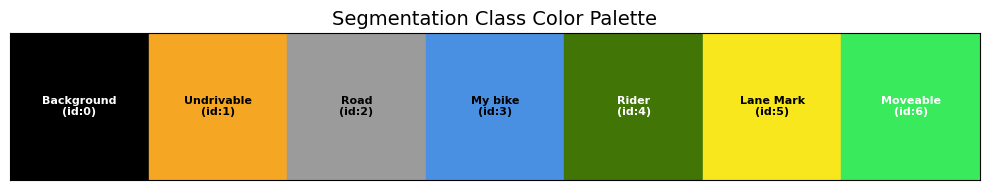

In [3]:
CLASS_INFO = {
    'Background':  {'color': (0, 0, 0),       'id': 0},
    'Undrivable':  {'color': (245, 166, 35),   'id': 1},
    'Road':        {'color': (155, 155, 155),  'id': 2},
    'My bike':     {'color': (74, 144, 226),   'id': 3},
    'Rider':       {'color': (65, 117, 6),     'id': 4},
    'Lane Mark':   {'color': (248, 231, 28),   'id': 5},
    'Moveable':    {'color': (57, 234, 92),    'id': 6},
}

NUM_CLASSES = len(CLASS_INFO)
CLASS_NAMES = list(CLASS_INFO.keys())
LANE_MARK_ID = 5  # Lane Mark class index

COLOR_TO_CLASS = {info['color']: info['id'] for info in CLASS_INFO.values()}

print(f"Total classes: {NUM_CLASSES}")
print(f"Class list: {CLASS_NAMES}")
print(f"Lane Mark class ID: {LANE_MARK_ID}")

# Color palette visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
for i, (name, info) in enumerate(CLASS_INFO.items()):
    color_normalized = tuple(c / 255.0 for c in info['color'])
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color_normalized))
    ax.text(i + 0.5, 0.5, f"{name}\n(id:{info['id']})",
            ha='center', va='center', fontsize=8, fontweight='bold',
            color='white' if sum(info['color']) < 400 else 'black')
ax.set_xlim(0, NUM_CLASSES)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Segmentation Class Color Palette', fontsize=14)
plt.tight_layout()
plt.show()

---
## 4. Feature Engineering - CLAHE Preprocessing

CLAHE (Contrast Limited Adaptive Histogram Equalization) enhances local contrast,
especially effective for night images where lane marks are barely visible.
Applied on the L channel of LAB color space to preserve color information.

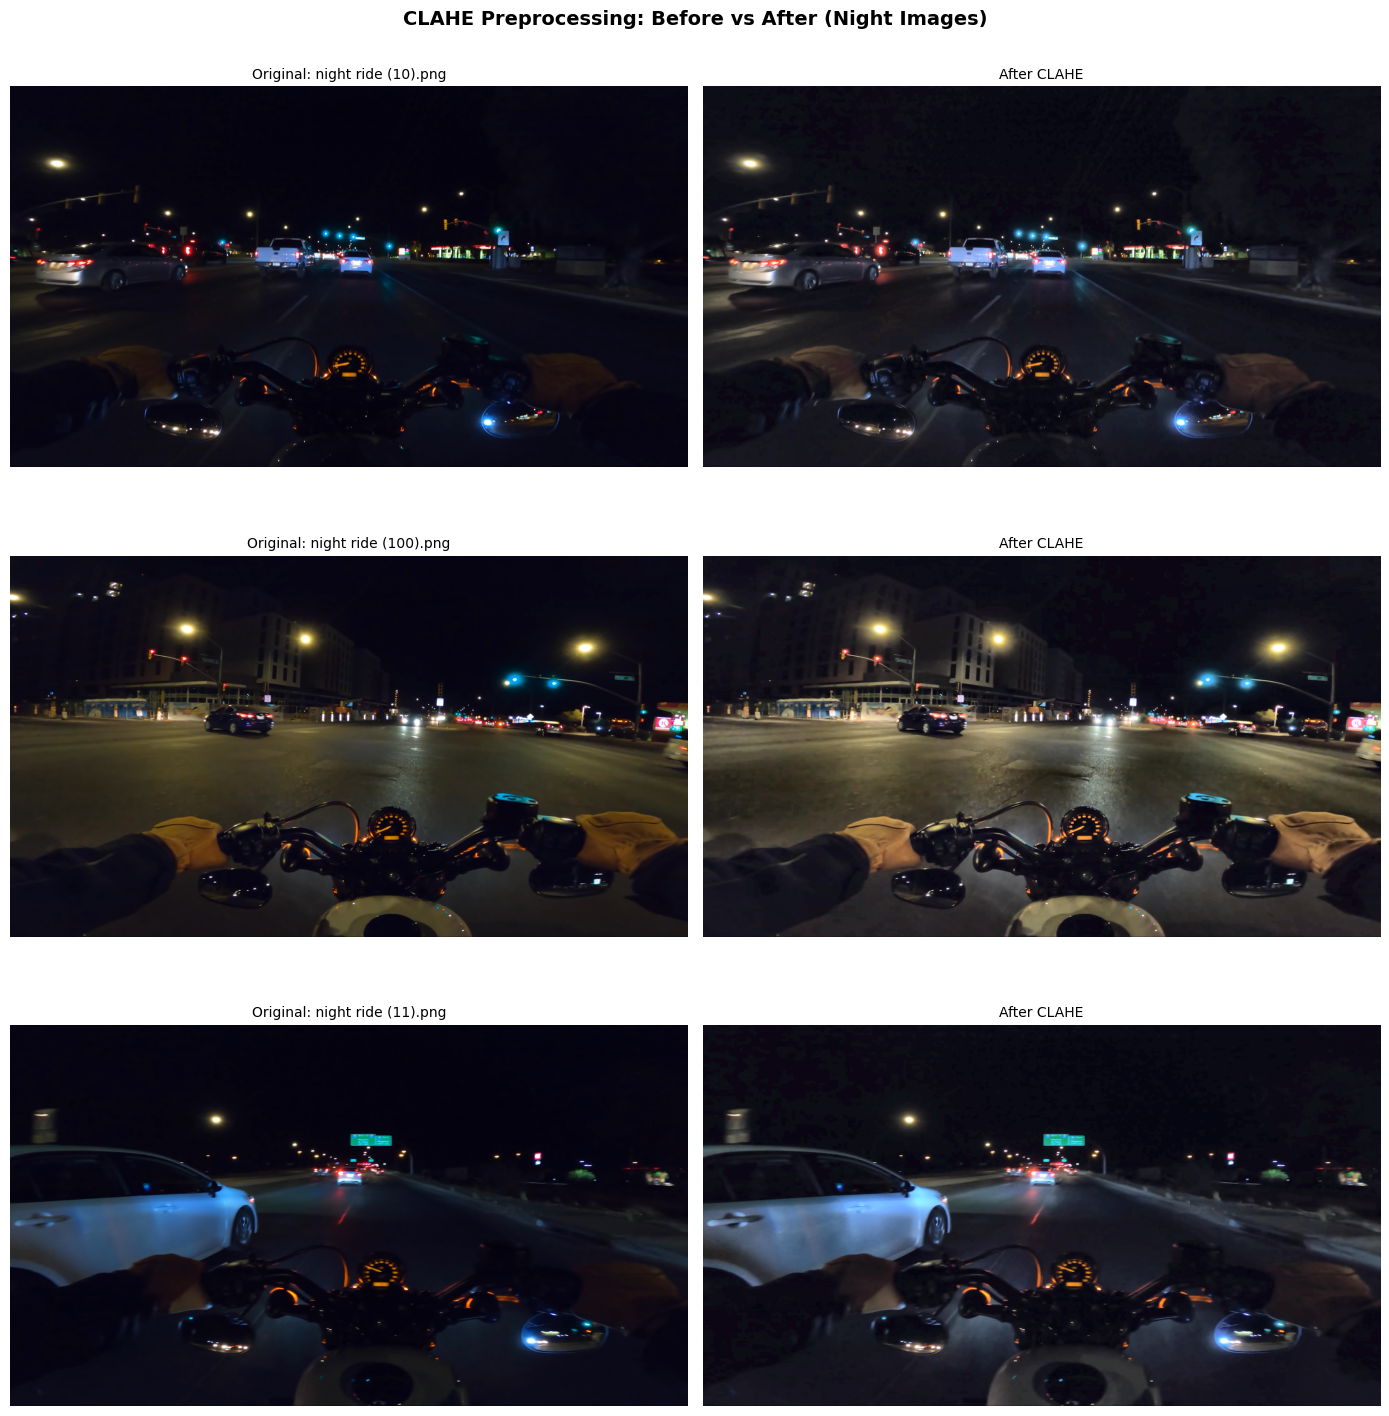

CLAHE enhances lane mark visibility in dark regions
Parameters: clipLimit=2.0, tileGridSize=(8,8)


In [4]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE on LAB L-channel, return RGB image."""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Visualize CLAHE effect on night images
night_samples = [f for f in all_image_files if f.startswith('night ride')][:3]
if len(night_samples) < 3:
    night_samples = all_image_files[:3]

fig, axes = plt.subplots(len(night_samples), 2, figsize=(14, 5 * len(night_samples)))
for row, img_name in enumerate(night_samples):
    img = np.array(Image.open(os.path.join(IMAGE_DIR, img_name)).convert('RGB'))
    img_clahe = apply_clahe(img)

    axes[row, 0].imshow(img)
    axes[row, 0].set_title(f'Original: {img_name}', fontsize=10)
    axes[row, 0].axis('off')

    axes[row, 1].imshow(img_clahe)
    axes[row, 1].set_title('After CLAHE', fontsize=10)
    axes[row, 1].axis('off')

plt.suptitle('CLAHE Preprocessing: Before vs After (Night Images)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("CLAHE enhances lane mark visibility in dark regions")
print(f"Parameters: clipLimit=2.0, tileGridSize=(8,8)")

---
## 5. Data Preprocessing

### 5-1. Mask Conversion Function

In [5]:
def rgb_mask_to_class_mask(rgb_mask):
    """Convert RGB fuse mask to class index mask."""
    h, w = rgb_mask.shape[:2]
    class_mask = np.zeros((h, w), dtype=np.int64)
    for color, class_id in COLOR_TO_CLASS.items():
        match = np.all(rgb_mask == np.array(color), axis=-1)
        class_mask[match] = class_id
    return class_mask

# Verify conversion
test_fuse = np.array(Image.open(
    os.path.join(IMAGE_DIR, all_image_files[0] + '___fuse.png')
).convert('RGB'))
test_mask = rgb_mask_to_class_mask(test_fuse)

print(f"RGB mask shape: {test_fuse.shape}")
print(f"Class mask shape: {test_mask.shape}")
print(f"Unique classes: {np.unique(test_mask)}")

RGB mask shape: (1080, 1920, 3)
Class mask shape: (1080, 1920)
Unique classes: [1 2 3 4 5 6]


### 5-2. Train / Validation Split

In [6]:
train_files, val_files = train_test_split(all_image_files, test_size=0.2, random_state=42)
print(f"Train: {len(train_files)} images | Validation: {len(val_files)} images")

Train: 160 images | Validation: 40 images


### 5-3. Dataset Class with CLAHE

In [7]:
class MotorcycleDatasetCLAHE(Dataset):
    """Dataset with CLAHE preprocessing for enhanced night visibility."""
    def __init__(self, image_files, image_dir, transform=None, apply_clahe_flag=True):
        self.image_files = image_files
        self.image_dir = image_dir
        self.transform = transform
        self.apply_clahe_flag = apply_clahe_flag

    def __len__(self):
        return len(self.image_files)

    def _apply_clahe(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = np.array(Image.open(os.path.join(self.image_dir, img_name)).convert('RGB'))
        mask_rgb = np.array(Image.open(
            os.path.join(self.image_dir, img_name + '___fuse.png')
        ).convert('RGB'))
        mask = rgb_mask_to_class_mask(mask_rgb)

        # Apply CLAHE before augmentation
        if self.apply_clahe_flag:
            image = self._apply_clahe(image)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask

print("MotorcycleDatasetCLAHE class defined.")

MotorcycleDatasetCLAHE class defined.


### 5-4. Augmentation & DataLoader

Key changes vs baseline:
- **512x512** (was 256) - preserves thin lane marks
- **A.CLAHE** - additional augmentation-level CLAHE
- **Sharpen** - enhance edge features
- **RandomGamma** - simulate varying lighting
- **Batch size 4** (was 8) - due to larger image size

In [8]:
IMG_SIZE = 512
BATCH_SIZE = 4
NUM_WORKERS = 0  # Must be 0 for macOS Jupyter

train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.RandomGamma(gamma_limit=(70, 130), p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

train_dataset = MotorcycleDatasetCLAHE(train_files, IMAGE_DIR, transform=train_transform, apply_clahe_flag=True)
val_dataset = MotorcycleDatasetCLAHE(val_files, IMAGE_DIR, transform=val_transform, apply_clahe_flag=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

# Verify shapes
images, masks = next(iter(train_loader))
print(f"Image batch: {images.shape} | Mask batch: {masks.shape}")
print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Mask classes: {torch.unique(masks).tolist()}")
print(f"\nConfig: IMG_SIZE={IMG_SIZE}, BATCH_SIZE={BATCH_SIZE}")

Image batch: torch.Size([4, 3, 512, 512]) | Mask batch: torch.Size([4, 512, 512])
Image value range: [-2.118, 2.640]
Mask classes: [1, 2, 3, 4, 5, 6]

Config: IMG_SIZE=512, BATCH_SIZE=4


---
## 6. Model - DeepLabV3+ (ResNet50)

DeepLabV3+ uses Atrous Spatial Pyramid Pooling (ASPP) to capture multi-scale context,
which helps detect both thin lane marks and large road areas simultaneously.

In [9]:
model = smp.DeepLabV3Plus(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None,
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: DeepLabV3+ + ResNet50 (ImageNet pretrained)")
print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")

# Verify output shape (eval mode required - ASPP pooling reduces to 1x1, BatchNorm fails with batch=1 in train mode)
model.eval()
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)
with torch.no_grad():
    output = model(dummy)
print(f"Input: {dummy.shape} -> Output: {output.shape}")
model.train();

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Model: DeepLabV3+ + ResNet50 (ImageNet pretrained)
Total params: 26,679,127 | Trainable: 26,679,127
Input: torch.Size([1, 3, 512, 512]) -> Output: torch.Size([1, 7, 512, 512])


---
## 7. Loss Function - Lane Mark Specialized

Three-component loss targeting Lane Mark:
1. **Focal Loss** (gamma=3.0, class weights) - handles class imbalance
2. **Dice Loss** (multiclass) - overlap-based loss
3. **Lane Mark Binary Dice** - dedicated loss for lane mark class

In [10]:
# Class weights based on inverse pixel frequency
# Approximate pixel ratios from EDA: Background ~43%, Road ~25%, Undrivable ~13%,
# My bike ~8%, Moveable ~5%, Rider ~4%, Lane Mark ~1.44%
pixel_ratios = np.array([0.43, 0.13, 0.25, 0.08, 0.04, 0.0144, 0.05])
inv_freq = 1.0 / (pixel_ratios + 1e-6)
class_weights = inv_freq / inv_freq.sum() * NUM_CLASSES  # normalize to mean=1
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class Weights (inverse frequency):")
for name, w in zip(CLASS_NAMES, class_weights):
    marker = " <<<" if name == 'Lane Mark' else ""
    print(f"  {name:<15} {w:.4f}{marker}")

# Focal Loss with class weights
class FocalLoss(nn.Module):
    def __init__(self, gamma=3.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, pred, target):
        ce_loss = F.cross_entropy(pred, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

# Lane Mark binary dice loss
class LaneMarkDiceLoss(nn.Module):
    def __init__(self, lane_class_id=5, smooth=1.0):
        super().__init__()
        self.lane_class_id = lane_class_id
        self.smooth = smooth

    def forward(self, pred, target):
        # Extract lane mark probability
        pred_softmax = F.softmax(pred, dim=1)
        pred_lane = pred_softmax[:, self.lane_class_id]  # (B, H, W)
        target_lane = (target == self.lane_class_id).float()  # (B, H, W)

        intersection = (pred_lane * target_lane).sum()
        union = pred_lane.sum() + target_lane.sum()
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice

# Initialize loss components
criterion_focal = FocalLoss(gamma=3.0, weight=class_weights_tensor)
criterion_dice = smp.losses.DiceLoss(mode='multiclass', from_logits=True)
criterion_lane_dice = LaneMarkDiceLoss(lane_class_id=LANE_MARK_ID)

def combined_loss(pred, target):
    loss_focal = criterion_focal(pred, target)
    loss_dice = criterion_dice(pred, target)
    loss_lane = criterion_lane_dice(pred, target)
    return 0.4 * loss_focal + 0.3 * loss_dice + 0.3 * loss_lane

print(f"\nLoss: Focal(0.4, gamma=3.0) + Dice(0.3) + LaneDice(0.3)")

Class Weights (inverse frequency):
  Background      0.1155
  Undrivable      0.3820
  Road            0.1986
  My bike         0.6208
  Rider           1.2415
  Lane Mark       3.4484 <<<
  Moveable        0.9932

Loss: Focal(0.4, gamma=3.0) + Dice(0.3) + LaneDice(0.3)


---
## 8. Optimizer & Scheduler

In [11]:
NUM_EPOCHS = 50
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

print(f"Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print(f"Scheduler: CosineAnnealingLR (T_max={NUM_EPOCHS}, eta_min=1e-6)")
print(f"Epochs: {NUM_EPOCHS}")

Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
Scheduler: CosineAnnealingLR (T_max=50, eta_min=1e-6)
Epochs: 50


---
## 9. Evaluation Metrics

In [12]:
def calculate_iou_per_class(pred, target, num_classes):
    """Calculate IoU for each class."""
    ious = []
    pred = pred.flatten()
    target = target.flatten()
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()
        ious.append(intersection / union if union > 0 else float('nan'))
    return ious

def calculate_metrics(pred, target, num_classes):
    """Calculate mIoU and pixel accuracy."""
    ious = calculate_iou_per_class(pred, target, num_classes)
    valid_ious = [iou for iou in ious if not np.isnan(iou)]
    miou = np.mean(valid_ious) if valid_ious else 0.0
    pixel_acc = (pred == target).sum().item() / target.numel()
    return miou, pixel_acc, ious

---
## 10. Training

In [13]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_miou, total_acc, n = 0, 0, 0, 0

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device).long()

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        miou, acc, _ = calculate_metrics(preds.cpu(), masks.cpu(), NUM_CLASSES)

        total_loss += loss.item()
        total_miou += miou
        total_acc += acc
        n += 1

    return total_loss / n, total_miou / n, total_acc / n


@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss, total_miou, total_acc, n = 0, 0, 0, 0
    all_ious = [[] for _ in range(NUM_CLASSES)]

    for images, masks in loader:
        images, masks = images.to(device), masks.to(device).long()

        outputs = model(images)
        loss = criterion(outputs, masks)

        preds = outputs.argmax(dim=1)
        miou, acc, ious = calculate_metrics(preds.cpu(), masks.cpu(), NUM_CLASSES)

        total_loss += loss.item()
        total_miou += miou
        total_acc += acc

        for i, iou in enumerate(ious):
            if not np.isnan(iou):
                all_ious[i].append(iou)
        n += 1

    class_ious = {CLASS_NAMES[i]: np.mean(all_ious[i]) if all_ious[i] else 0.0
                  for i in range(NUM_CLASSES)}

    return total_loss / n, total_miou / n, total_acc / n, class_ious

In [ ]:
history = {
    'train_loss': [], 'val_loss': [],
    'train_miou': [], 'val_miou': [],
    'train_acc': [], 'val_acc': [],
    'lane_mark_iou': [],
}
best_miou = 0.0

print(f"{'='*75}")
print(f"DeepLabV3+ (ResNet50) + CLAHE + Lane Mark Loss Training Start")
print(f"Epochs: {NUM_EPOCHS} | Batch: {BATCH_SIZE} | Image: {IMG_SIZE}x{IMG_SIZE}")
print(f"Loss: Focal(0.4) + Dice(0.3) + LaneDice(0.3)")
print(f"{'='*75}")

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_miou, train_acc = train_one_epoch(
        model, train_loader, combined_loss, optimizer, device)
    val_loss, val_miou, val_acc, class_ious = validate(
        model, val_loader, combined_loss, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_miou'].append(train_miou)
    history['val_miou'].append(val_miou)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['lane_mark_iou'].append(class_ious.get('Lane Mark', 0.0))

    if val_miou > best_miou:
        best_miou = val_miou
        torch.save(model.state_dict(), 'best_deeplabv3_lane.pth')

    if epoch % 5 == 0 or epoch == 1:
        lane_iou = class_ious.get('Lane Mark', 0.0)
        print(f"[{epoch:>3}/{NUM_EPOCHS}] "
              f"Train - Loss: {train_loss:.4f} mIoU: {train_miou:.4f} | "
              f"Val - Loss: {val_loss:.4f} mIoU: {val_miou:.4f} Acc: {val_acc:.4f} | "
              f"Lane IoU: {lane_iou:.4f}")

print(f"\nTraining complete! Best Val mIoU: {best_miou:.4f}")

DeepLabV3+ (ResNet50) + CLAHE + Lane Mark Loss Training Start
Epochs: 50 | Batch: 4 | Image: 512x512
Loss: Focal(0.4) + Dice(0.3) + LaneDice(0.3)
[  1/50] Train - Loss: 0.5391 mIoU: 0.2864 | Val - Loss: 0.4875 mIoU: 0.4008 Acc: 0.6520 | Lane IoU: 0.0695
[  5/50] Train - Loss: 0.2637 mIoU: 0.6805 | Val - Loss: 0.3034 mIoU: 0.6487 Acc: 0.8755 | Lane IoU: 0.3579
[ 10/50] Train - Loss: 0.1780 mIoU: 0.7499 | Val - Loss: 0.2449 mIoU: 0.7215 Acc: 0.9102 | Lane IoU: 0.4456


---
## 11. Training Curves

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train', color='blue')
axes[0].plot(history['val_loss'], label='Val', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# mIoU
axes[1].plot(history['train_miou'], label='Train', color='blue')
axes[1].plot(history['val_miou'], label='Val', color='red')
axes[1].plot(history['lane_mark_iou'], label='Lane Mark IoU', color='gold', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('mIoU')
axes[1].set_title('mIoU & Lane Mark IoU')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Pixel Accuracy
axes[2].plot(history['train_acc'], label='Train', color='blue')
axes[2].plot(history['val_acc'], label='Val', color='red')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Pixel Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('DeepLabV3+ Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 12. Final Evaluation

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_deeplabv3_lane.pth', map_location=device))
val_loss, val_miou, val_acc, class_ious = validate(model, val_loader, combined_loss, device)

print("=" * 65)
print(f"DeepLabV3+ (ResNet50) Final Results")
print("=" * 65)
print(f"  mIoU:           {val_miou:.4f} ({val_miou*100:.2f}%)")
print(f"  Pixel Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print()
print(f"  Per-class IoU:")
print(f"  {'-'*50}")
for name, iou in class_ious.items():
    bar = '\u2588' * int(iou * 30)
    marker = ' <<< TARGET' if name == 'Lane Mark' else ''
    print(f"  {name:<15} {iou:.4f} ({iou*100:.2f}%) {bar}{marker}")

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
names = list(class_ious.keys())
values = list(class_ious.values())
colors = [tuple(c/255 for c in CLASS_INFO[n]['color']) for n in names]
bars = ax.barh(names, values, color=colors, edgecolor='black')
ax.set_xlabel('IoU')
ax.set_title(f'Per-Class IoU (mIoU: {val_miou:.4f})')
ax.set_xlim(0, 1)
for bar, val in zip(bars, values):
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=10)
ax.axvline(val_miou, color='red', linestyle='--', alpha=0.7, label=f'mIoU: {val_miou:.3f}')
ax.legend()
plt.tight_layout()
plt.show()

---
## 13. Prediction Visualization

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=6):
    model.eval()
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 5 * num_samples))
    if num_samples == 1:
        axes = axes[np.newaxis, :]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for row, idx in enumerate(indices):
        image, mask = dataset[idx]

        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred = pred.argmax(dim=1).squeeze(0).cpu().numpy()

        img = image.permute(1, 2, 0).numpy()
        img = (img * std + mean).clip(0, 1)
        mask_np = mask.numpy()

        axes[row, 0].imshow(img)
        axes[row, 0].set_title('Original (CLAHE applied)')
        axes[row, 0].axis('off')

        axes[row, 1].imshow(mask_np, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[row, 1].set_title('Ground Truth (GT)')
        axes[row, 1].axis('off')

        axes[row, 2].imshow(pred, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[row, 2].set_title('Prediction (Pred)')
        axes[row, 2].axis('off')

    legend_patches = [mpatches.Patch(color=plt.cm.tab10(i/10), label=name)
                      for i, name in enumerate(CLASS_NAMES)]
    fig.legend(handles=legend_patches, loc='lower center', ncol=7,
              fontsize=10, bbox_to_anchor=(0.5, -0.02))
    plt.suptitle('Prediction Results: Original | Ground Truth | Prediction', fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, device, num_samples=6)

---
## 14. Baseline Comparison

U-Net (ResNet34) vs DeepLabV3+ (ResNet50) performance comparison.

In [ ]:
# Baseline results (from unet.ipynb)
baseline_results = {
    'mIoU': 0.5933,
    'Pixel Accuracy': 0.9264,
    'Background': 0.9365,
    'Undrivable': 0.5854,
    'Road': 0.9081,
    'My bike': 0.8219,
    'Rider': 0.5771,
    'Lane Mark': 0.0000,
    'Moveable': 0.3244,
}

# Current model results
deeplabv3_results = {
    'mIoU': val_miou,
    'Pixel Accuracy': val_acc,
}
deeplabv3_results.update(class_ious)

# Comparison table
print("=" * 75)
print(f"{'Metric':<18} {'U-Net (Baseline)':>18} {'DeepLabV3+ (Ours)':>18} {'Diff':>10}")
print("=" * 75)
for key in baseline_results:
    bl = baseline_results[key]
    dl = deeplabv3_results.get(key, 0.0)
    diff = dl - bl
    marker = ' <<<' if key == 'Lane Mark' else ''
    print(f"  {key:<16} {bl:>17.4f} {dl:>17.4f} {diff:>+9.4f}{marker}")
print("=" * 75)

# Visual comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(NUM_CLASSES)
width = 0.35

baseline_ious = [baseline_results[name] for name in CLASS_NAMES]
deeplabv3_ious = [class_ious[name] for name in CLASS_NAMES]

bars1 = ax.bar(x - width/2, baseline_ious, width, label='U-Net (Baseline)', color='lightcoral', edgecolor='black')
bars2 = ax.bar(x + width/2, deeplabv3_ious, width, label='DeepLabV3+ (Ours)', color='steelblue', edgecolor='black')

ax.set_xlabel('Class')
ax.set_ylabel('IoU')
ax.set_title('Per-Class IoU: U-Net vs DeepLabV3+')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=30, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

# Annotate Lane Mark improvement
lane_idx = CLASS_NAMES.index('Lane Mark')
ax.annotate(f'Lane Mark\n{baseline_ious[lane_idx]:.3f} -> {deeplabv3_ious[lane_idx]:.3f}',
            xy=(lane_idx, max(deeplabv3_ious[lane_idx], 0.05)),
            xytext=(lane_idx + 0.8, 0.7),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=11, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

---
## 15. Summary & Conclusion

### DeepLabV3+ Configuration
- **Model**: DeepLabV3+ + ResNet50 (ImageNet pretrained)
- **Loss**: Focal(0.4, gamma=3.0) + Dice(0.3) + LaneMarkDice(0.3) + Class Weights
- **Image**: 512x512 | **Batch**: 4 | **Epochs**: 50
- **Preprocessing**: CLAHE (LAB L-channel, clipLimit=2.0)
- **Augmentation**: HorizontalFlip, CLAHE, RandomBrightnessContrast(0.3), RandomGamma, Sharpen
- **Optimizer**: AdamW (lr=1e-4) | **Scheduler**: CosineAnnealingLR

### Key Improvements vs Baseline
| Component | Baseline (U-Net) | Improved (DeepLabV3+) |
|-----------|-----------------|----------------------|
| Model | U-Net | DeepLabV3+ (ASPP) |
| Backbone | ResNet34 | ResNet50 |
| Resolution | 256x256 | 512x512 |
| Preprocessing | None | CLAHE |
| Loss | CE + Dice | Focal + Dice + LaneDice |
| Class Weights | None | Inverse frequency |
| Augmentation | Basic | + CLAHE, Sharpen, Gamma |